<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/ADDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.autograd import Function
from torch import optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import xgboost
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import shuffle
import warnings 
warnings.simplefilter('ignore')

In [2]:
class ADDA(nn.Module):
  def __init__(self,src_x,src_y,tgt_x,tgt_y):
    super().__init__()
    '''
    src_x : 模擬數據的x type:pd.DataFrame()
    src_y : 模擬數據的y type:pd.DataFrame()
    tgt_x : 真實數據的x type:pd.DataFrame()
    tgt_y : 真實數據的y type:pd.DataFrame()
    '''
    
    # config
    self.x_col = src_x.columns.tolist()
    self.y_col = src_y.columns.tolist()
    self.α = 0.00005
    self.c = 0.01
    self.m = 64
    self.ncritic = 5
    self.input_dim = src_x.shape[1]
    self.output_dim = src_y.shape[1]
    
    # scaled feature
    self.scaler_x =  StandardScaler().fit(src_x.loc[:])
    src_x.loc[:] = self.scaler_x.transform(src_x.loc[:])
    tgt_x.loc[:] = self.scaler_x.transform(tgt_x.loc[:])
    
    # to torch.FloatTensor
    src_x,src_y = torch.FloatTensor(src_x.values),torch.FloatTensor(src_y.values)
    tgt_x,tgt_y = torch.FloatTensor(tgt_x.values),torch.FloatTensor(tgt_y.values)
    
    # make data_iter
    self.src_dataset = TensorDataset(src_x,src_y)
    self.tgt_dataset = TensorDataset(tgt_x,tgt_y)
    
    # src data encoder
    self.SRC_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # target data encoder
    self.TGT_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # regression model
    self.regression = nn.Sequential(
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,self.output_dim),
        )
    
    # discriminator or call critic
    self.discriminator = nn.Sequential(
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,1),# 1.判别器最后一层去掉sigmoid
    )
    
    # optimizer
    self.S_optimizer = optim.Adam(self.SRC_F.parameters(),lr=1e-3)
    self.R_optimizer = optim.Adam(self.regression.parameters(),lr=1e-3)

    # 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp
    self.T_optimizer = optim.RMSprop(self.TGT_F.parameters(),lr=self.α)
    self.D_optimizer = optim.RMSprop(self.discriminator.parameters(),lr=self.α)
  
  def forward(self,src_x,tgt_x):
    src_feat,tgt_feat = self.SRC_F(src_x),self.TGT_F(tgt_x)
    src_reg,tgt_reg = self.regression(src_feat),self.regression(tgt_feat)
    src_domain,tgt_domain = self.discriminator(src_feat),self.discriminator(tgt_feat)
    return src_reg,src_domain,tgt_reg,tgt_domain
  
  def train_S_R(self,src_x,src_y):
    '''
    input : src_x(FloatTensor),src_y(FloatTensor)
    output : loss(Scalar)
    update_method : 一般監督學習
    '''
    
    self.SRC_F.train()
    self.regression.train()
    
    # forward
    src_feat = self.SRC_F(src_x)
    y_hat = self.regression(src_feat)
    
    # compute loss by mse
    loss = ((y_hat-src_y)**2).mean()
    loss.backward()
    
    # update weight
    self.S_optimizer.step()
    self.R_optimizer.step()
    self.S_optimizer.zero_grad()
    self.R_optimizer.zero_grad()
    
    return loss.item()
  
  def train_T_D(self,src_x,tgt_x,tgt_y):
    '''
    input: src_x(FloatTensor),tgt_x(FloatTensor)
    return :d_loss(Scalar),t_loss(Scalar)
    '''
    # 2.生成器和判别器的loss不取log
    # train discriminator ncritic times
    for i in range(self.ncritic):
      src_feat = self.SRC_F(src_x).detach()
      tgt_feat = self.TGT_F(tgt_x).detach()
      d_loss = -torch.mean(self.discriminator(src_feat)) + torch.mean(self.discriminator(tgt_feat))
      d_loss.backward()
      self.D_optimizer.step()
      self.D_optimizer.zero_grad()
      # 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
      for p in self.discriminator.parameters():
        p.data.clamp_(-self.c,self.c)
    
    # train TGT_F
    tgt_feat = self.TGT_F(tgt_x)
    t_loss = torch.mean(-self.discriminator(tgt_feat))
    t_loss.backward()
    self.T_optimizer.step()
    self.T_optimizer.zero_grad()

    # train regression
    tgt_reg = self.regression(tgt_feat.detach())
    r_loss = ((tgt_reg-tgt_y)**2).mean()
    r_loss.backward()
    self.R_optimizer.step()
    self.R_optimizer.zero_grad()
    
    return d_loss.item(),t_loss.item(),r_loss.item()

  def get_predict(self,tgt_x):
    '''
    input: pd.DataFrame()
    output: pd.DataFrame()
    '''
    tgt_x = self.scaler_x.transform(tgt_x)
    tgt_x = torch.FloatTensor(tgt_x)
    tgt_feat = self.TGT_F(tgt_x)
    tgt_reg = self.regression(tgt_feat).detach().cpu().numpy()
    tgt_reg = pd.DataFrame(tgt_reg,columns=self.y_col)
    return tgt_reg

# get data

In [3]:
src_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/train_4565.csv',index_col=0))
tgt_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/test_250.csv',index_col=0))
tgt_data,final_test_data = tgt_data.iloc[:200],tgt_data.iloc[200:]
x_col = ['T10','T50','T90','N+A']
y_col = src_data.drop(x_col,axis=1).columns.tolist()
src_x,src_y = src_data[x_col],src_data[y_col]
tgt_x,tgt_y = tgt_data[x_col],tgt_data[y_col]
model = ADDA(src_x,src_y,tgt_x,tgt_y)

In [4]:

xgb = MultiOutputRegressor(xgboost.XGBRegressor())
xgb.fit(tgt_x,tgt_y)
xgb

[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbos

# train stage_1

ep:0 loss:30.964710235595703
ep:100 loss:1.5873883962631226
ep:200 loss:0.5250117778778076
ep:300 loss:0.5116539597511292
ep:400 loss:0.5486520528793335
ep:500 loss:0.46271979808807373
ep:600 loss:0.7133937478065491
ep:700 loss:0.5201096534729004
ep:800 loss:0.2976348400115967
ep:900 loss:0.6283544301986694


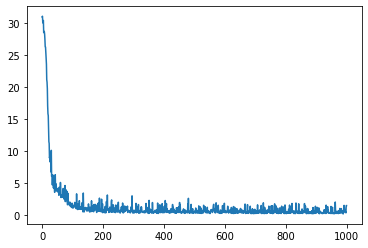

In [5]:
history = []
for ep in range(1000):
  idx = random.sample([*range(len(model.src_dataset))],model.m)
  src_x,src_y = model.src_dataset[idx]
  loss = model.train_S_R(src_x,src_y)
  history.append(loss)
  if ep % 100 == 0:
    print("ep:{} loss:{}".format(ep,loss))
plt.plot(history)

# train_stage_2

In [6]:
d_history = []
t_history = []
r_history = []
for ep in range(10000):
  tgt_idx = random.sample([*range(len(model.tgt_dataset))],model.m)
  src_idx = random.sample([*range(len(model.src_dataset))],model.m)
  tgt_x,tgt_y = model.tgt_dataset[tgt_idx]
  src_x,src_y = model.src_dataset[src_idx]
  d_loss,t_loss,r_loss = model.train_T_D(src_x,tgt_x,tgt_y)
  d_history.append(d_loss)
  t_history.append(t_loss)
  r_history.append(r_loss)
  if ep % 100 == 0:
    print("ep:{} d_loss:{} t_loss:{} r_loss:{}".format(ep,d_loss,t_loss,r_loss))

ep:0 d_loss:-0.013850359246134758 t_loss:0.010544581338763237 r_loss:23.06622314453125
ep:100 d_loss:-0.13172116875648499 t_loss:-0.292027086019516 r_loss:2.8084757328033447
ep:200 d_loss:-0.015177428722381592 t_loss:-0.3723464012145996 r_loss:1.7011200189590454
ep:300 d_loss:0.042995765805244446 t_loss:-0.264382541179657 r_loss:1.5521748065948486
ep:400 d_loss:-0.014339640736579895 t_loss:-0.06030953302979469 r_loss:1.4563220739364624
ep:500 d_loss:-0.051976192742586136 t_loss:0.06009528040885925 r_loss:1.0769823789596558
ep:600 d_loss:-0.026915062218904495 t_loss:0.02006346359848976 r_loss:1.2083549499511719
ep:700 d_loss:-0.018323607742786407 t_loss:-0.07599704712629318 r_loss:1.1730958223342896
ep:800 d_loss:-0.025120148435235023 t_loss:-0.01232194248586893 r_loss:0.8781407475471497
ep:900 d_loss:-0.03548194468021393 t_loss:0.02444332465529442 r_loss:0.9460970759391785
ep:1000 d_loss:-0.030757449567317963 t_loss:-0.010053489357233047 r_loss:1.008508324623108
ep:1100 d_loss:-0.00663

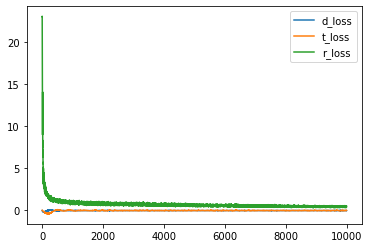

In [7]:
plt.plot(d_history,label='d_loss')
plt.plot(t_history,label='t_loss')
plt.plot(r_history,label='r_loss')
plt.legend()
plt.show()

# test

In [8]:
x_test = final_test_data[x_col]
y_test = final_test_data[y_col]

In [9]:
tgt_y_hat = model.get_predict(x_test)
tgt_y_hat.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,1.967004,1.169067,0.321175,3.068921,2.939453,5.435337,0.376962,4.613756,3.930918,16.903706,3.297493,6.646178,7.890873,11.130220,5.760192,4.339278,6.104572,4.125374,2.863643,1.358081,2.983050,0.492571,0.779647
1,1.146050,0.767632,0.168063,1.475003,1.701079,4.084516,0.584073,5.808597,5.543728,20.367847,6.070631,6.714122,9.890176,8.897176,7.316707,3.651217,6.225400,3.627035,2.418422,0.719097,2.283693,0.272058,0.523008
2,0.982002,0.608807,0.053925,0.395081,0.179845,5.023169,0.052827,6.498828,8.723955,30.205078,5.858113,3.783152,7.965072,9.429411,4.114882,1.462532,5.500713,4.772637,1.516639,0.336294,1.925984,0.561930,1.093093
3,6.049161,3.549170,0.664915,4.246045,5.153628,5.605090,2.349242,4.263895,4.944072,9.167409,4.477218,3.903529,1.454487,8.656179,4.836769,3.920809,5.996193,3.933147,2.892577,3.795438,5.479269,1.349410,3.706619
4,9.722069,8.888404,1.030276,5.237376,7.996978,6.614982,1.673859,4.602151,5.211425,10.555327,4.112462,4.152960,4.951302,4.513469,4.665284,2.881786,4.506051,2.455775,2.046210,1.514892,2.902665,0.279114,0.932750


In [10]:
xgb_y_hat = xgb.predict(x_test)
xgb_y_hat = pd.DataFrame(xgb_y_hat,columns=y_col)

In [11]:
y_test.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
242,1.418754,0.687240,0.292807,2.998501,2.901905,4.318646,0.528259,4.961613,5.265488,13.716632,3.311432,5.713251,7.690450,10.748317,4.561142,3.094091,8.054697,8.998521,2.986426,0.872383,4.441403,1.151102,1.286940
3,0.152985,0.054995,0.125987,2.097767,1.214444,7.428715,2.663734,6.475165,5.259181,15.397940,6.812319,7.602400,9.434827,8.037266,7.481252,3.877234,8.225184,3.917980,1.569843,0.421814,1.334506,0.127167,0.287296
126,0.002000,0.002000,0.000000,0.026997,0.004000,4.831517,0.038996,6.343502,9.040352,31.367471,5.111489,4.439939,8.609573,9.810202,4.050595,0.087930,6.530236,4.146758,1.333867,0.523053,2.136403,0.513909,1.049213
61,5.584684,4.501345,0.733457,3.152653,4.824999,6.428331,0.926870,2.729719,3.749362,11.706373,2.778611,3.442528,5.754385,6.795849,4.074430,3.288400,5.635783,5.216838,3.728478,3.486554,5.443976,1.224570,4.791807
68,10.003700,8.172938,0.964875,5.244318,7.521022,6.424165,1.252837,4.437544,5.111627,10.237256,3.229580,4.194910,5.476948,4.505298,4.159459,3.113259,4.758790,2.782567,2.466679,1.691456,2.616229,0.407186,1.227357


In [12]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_pred,y_real):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','RMSE','MAPE'])
  for i in y_pred.columns:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'RMSE'] = np.sqrt(mean_squared_error(y_real[i],y_pred[i]))
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [15]:
adda_res = show_metrics(tgt_y_hat,y_test)
adda_res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.975916,0.653349,1117.800783
C5IP,0.947137,0.699166,733.315286
C5N,0.902821,0.103775,inf
C6NP,0.944894,0.514680,108.548660
C6IP,0.924239,0.754468,228.038131
C6N,0.801801,0.925777,10.142115
C6A,0.509024,0.751994,73.565773
C7NP,0.627183,0.732678,8.916384
C7IP,0.905356,0.510899,7.306419
C7N,0.875114,2.084599,13.477771


In [16]:
xgb_res = show_metrics(xgb_y_hat,y_test)
xgb_res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,-0.671889,5.443533,1759.830367
C5IP,-1.107691,4.414760,321.022768
C5N,-1.017938,0.472888,inf
C6NP,-2.227022,3.938574,208.746709
C6IP,-1.792971,4.580907,694.802966
C6N,-3.688042,4.502473,65.006075
C6A,-0.625373,1.368236,102.909977
C7NP,-2.394594,2.210850,33.479690
C7IP,-0.640883,2.127285,22.464417
C7N,-1.914794,10.070924,92.557772


In [32]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='ADDA', x=y_col, y=adda_res['RMSE']),
    go.Bar(name='XGB', x=y_col, y=xgb_res['RMSE'])
])
# Change the bar mode
fig.update_layout(barmode='group',title='RMSE')
fig.show()

In [ ]:
\